# Demo: Numpy Dataset

In [1]:
import autoroot
from typing import Optional, Callable
import toolz 
import functools as ft
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.auto as tqdm
from rastervision.core.data import RasterioSource

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-11-20 12:27:10:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmput5f1ngf


In [2]:
from helio_tools._src.utils.io import get_list_filenames

base_path = "/home/juanjohn/data/helio/sdo_png/304"
ext = ".png" 

data_filenames = get_list_filenames(base_path, ext)
print(len(data_filenames))


5


In [3]:
import rasterio as rio
from os import PathLike
from PIL import Image
from os.path import splitext
from pathlib import Path


def load_image(path: PathLike) -> np.ndarray:
    """Read in image from path and return as a (H, W, C) numpy array."""
    # get extension
    ext = Path(path).suffix
    if ext == '.npy':
        img = np.load(path, mmap_mode="r+")
    elif ext in ['.tif', '.tiff']:
        with rio.open(path, 'r') as f:
            img = f.read()
            img = img.transpose(1, 2, 0)
    else:
        img = np.array(Image.open(path))

    return _make_2D(img)

def _make_2D(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:
        # (h, w) --> (h, w, 1)
        img = img[..., np.newaxis]

    return img


In [4]:
out = load_image(data_filenames[0])
out.shape

(2048, 2048, 1)

In [5]:
from typing import Optional, Callable
from torch.utils.data import Dataset, DataLoader

class ImageDataReader(Dataset):
    def __init__(self, data_dir: str, ext: str=".npy", transforms: Optional[Callable]=None):
        self.data_dir = data_dir
        self.data_filenames = get_list_filenames(data_dir, ext)
        self.transforms = transforms

    def __getitem__(self, ind) -> np.ndarray:
        img_path = self.data_filenames[ind]
        x = load_image(img_path)
        if self.transforms is not None:
            x = self.transforms(x)
        return x

    def __len__(self):
        return len(self.data_filenames)

In [6]:
import einops
import toolz
from sklearn.feature_extraction.image import extract_patches_2d
data_dir = "/home/juanjohn/data/helio/sdo_npy/304"
ext = ".npy" 


ds = ImageDataReader(data_dir, ext=ext, transforms=None)

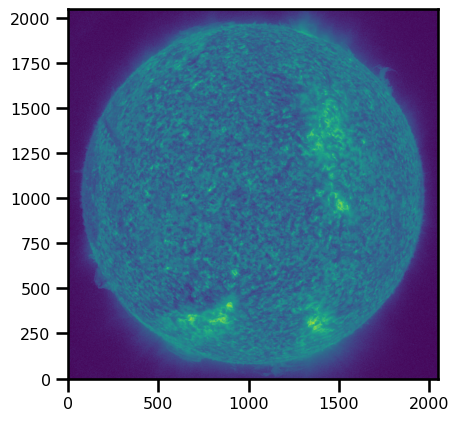

In [7]:
fig, ax = plt.subplots()

ax.imshow(ds[0][...,0].T, origin="lower")

plt.show()

### Patching

In [8]:
def random_patch_2D(x: np.ndarray, patch_size: tuple[int, int], **kwargs) -> np.ndarray:
    assert x.ndim >= 2 or x.ndim <= 3

    x = extract_patches_2d(x, patch_size=patch_size, max_patches=1, **kwargs)[0]

    return _make_2D(x)

In [9]:
patch_size = (256, 256)

In [10]:
out = random_patch_2D(ds[0], patch_size, random_state=123)

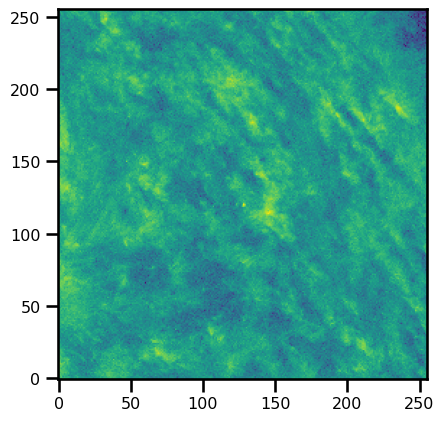

In [11]:
fig, ax = plt.subplots()

ax.imshow(out[...,0].T, origin="lower")

plt.show()

In [12]:
# perform patching
fn1 = toolz.partial(random_patch_2D, patch_size=patch_size, random_state=None)

# do reshaping
fn2 = lambda x: einops.rearrange(x, "H W 1 -> 1 H W")

In [13]:
transforms = toolz.compose_left(fn1, fn2)

In [15]:
# initialize dataset
ds = ImageDataReader(data_dir, ext=ext, transforms=transforms)

# initialize dataloader
batch_size = 32
dl = DataLoader(ds, batch_size=20, shuffle=None)

In [20]:
for xbatch in dl:
    break

In [21]:
xbatch.shape

torch.Size([20, 1, 256, 256])

In [22]:
len(ds)

539

## Configs

In [48]:
from hydra_zen import make_custom_builds_fn, builds, instantiate, to_yaml, load_from_yaml, save_as_yaml

pbuilds = make_custom_builds_fn(zen_partial=True, populate_full_signature=True)

In [60]:
train_transforms = builds(
    toolz.compose_left,
    pbuilds(random_patch_2D, patch_size=patch_size, random_state=None),
    pbuilds(einops.rearrange, pattern="H W 1 -> 1 H W")
)

DS = builds(
    ImageDataReader,
    data_dir=base_path,
    ext=".png",
    transforms=train_transforms
)

In [62]:
cfg = to_yaml(DS)

In [63]:
# save to a yaml file
config_path = "./SDO_DS_config.yaml"
save_as_yaml(DS, f=config_path)

In [64]:
# initialize config
config = load_from_yaml(config_path)

# load config
out = instantiate(config)

In [29]:
train_transforms

types.Builds_compose_left

In [ ]:
resolution = 2048



base_prepro = hydra_zen.make_config(
    zen_dataclass={'cls_name': 'dataset_tranform'},
    # 0 - get a filename
    _0=init_partial_fn(toolz.identity),
    # 1 - load fits file to a sunpy Map object
    _1=init_partial_fn(load_fits_to_map),
    # 2 - normalize radius via some resolution
    _2=init_partial_fn(normalize_radius, resolution=resolution, crop = True, padding_factor = 0.1),
    # 3 - correct degregation
    _3=init_partial_fn(correct_degregation, method = "auto"),
    # 4 - sunpy.map.Map --> numpy.ndarray
    _4=init_partial_fn(map_to_ndarray),
    # 5 - Normalize
    _5=init_partial_fn(
        normalize_fn, fn=init_fn(ImageNormalize, vmin=0, vmax=8_800, clip=True, stretch=init_fn(AsinhStretch, a=0.001))),
    # 6 - Reshape (Add batch dimension (?))
    _6=init_partial_fn(
        rearrange, pattern='H W -> H W 1', H=resolution, W=resolution)
)